<a href="https://colab.research.google.com/github/david2003-bite-10-23/generative_ai/blob/main/%E7%94%9F%E6%88%90%E5%BC%8FAI_0225%E4%BD%9C%E6%A5%AD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

內容大綱:
這一次的作業是實做一個神經網絡，我主要是實作一層的flatten加上4層的FC，FC的參數由大到小(256/128/64/32)這是為了避免過擬合，有加上基本的augmentation(縮放以及15度的小角度旋轉)，優化器改為Adam做自適應超參數調整，lr=0.001，其餘的部分基本不變

以下是訓練過程、最終的accuracy以及gradio的測試截圖
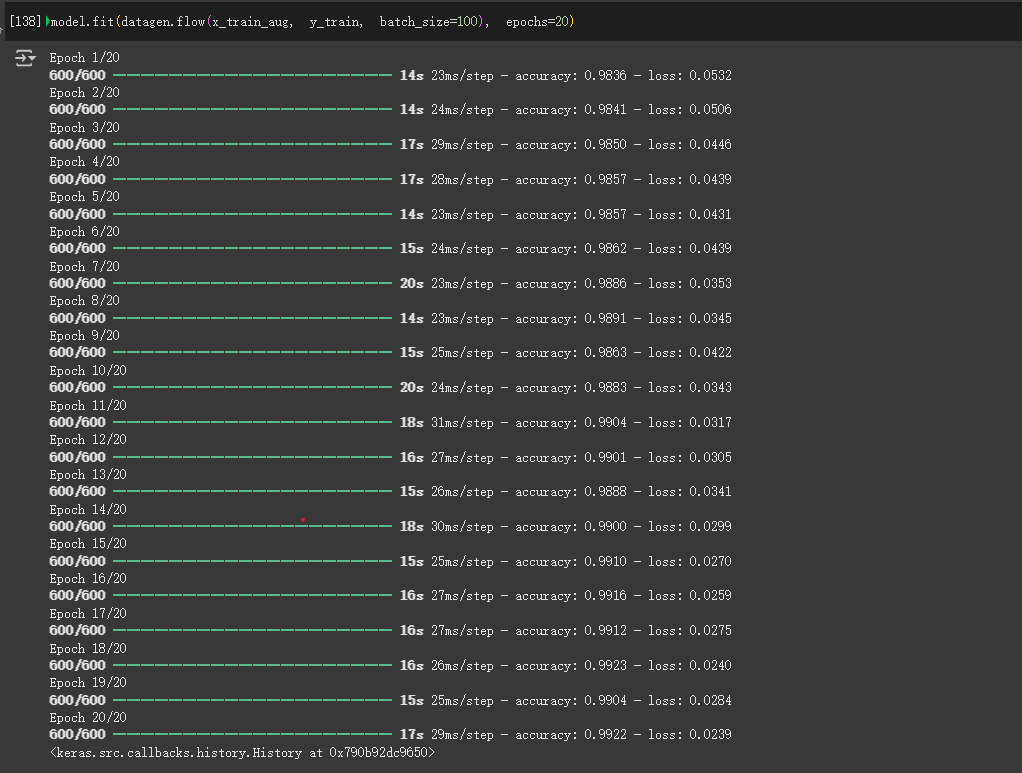
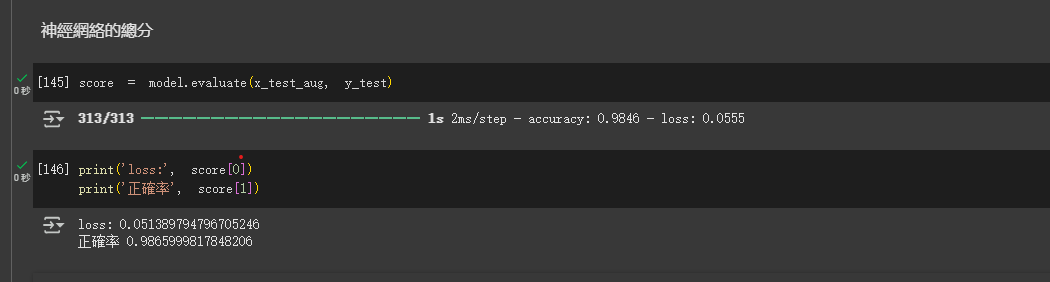
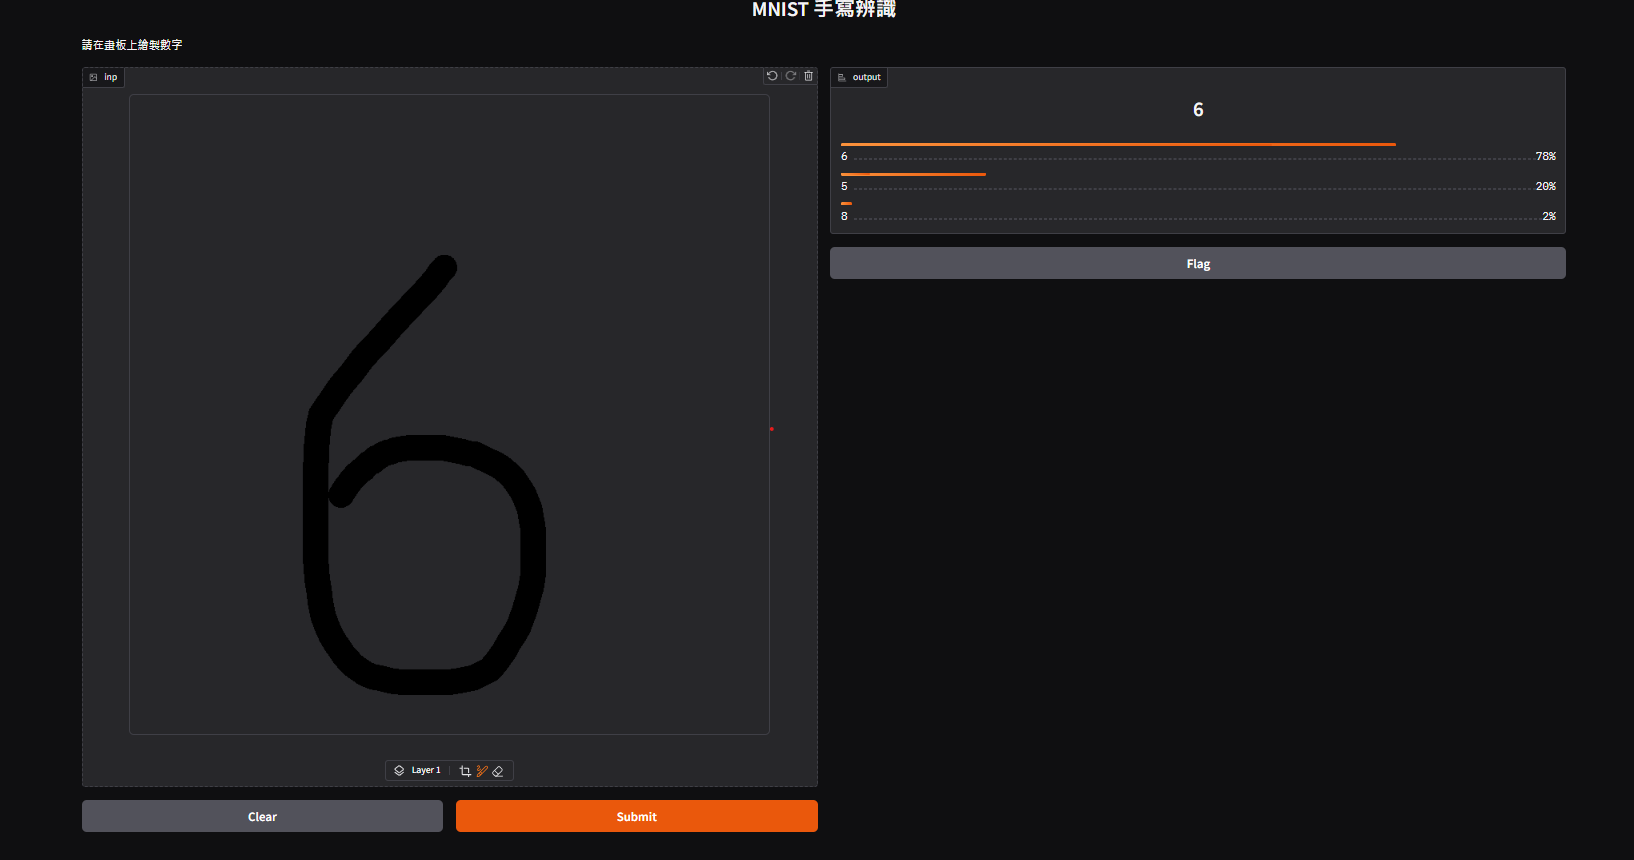
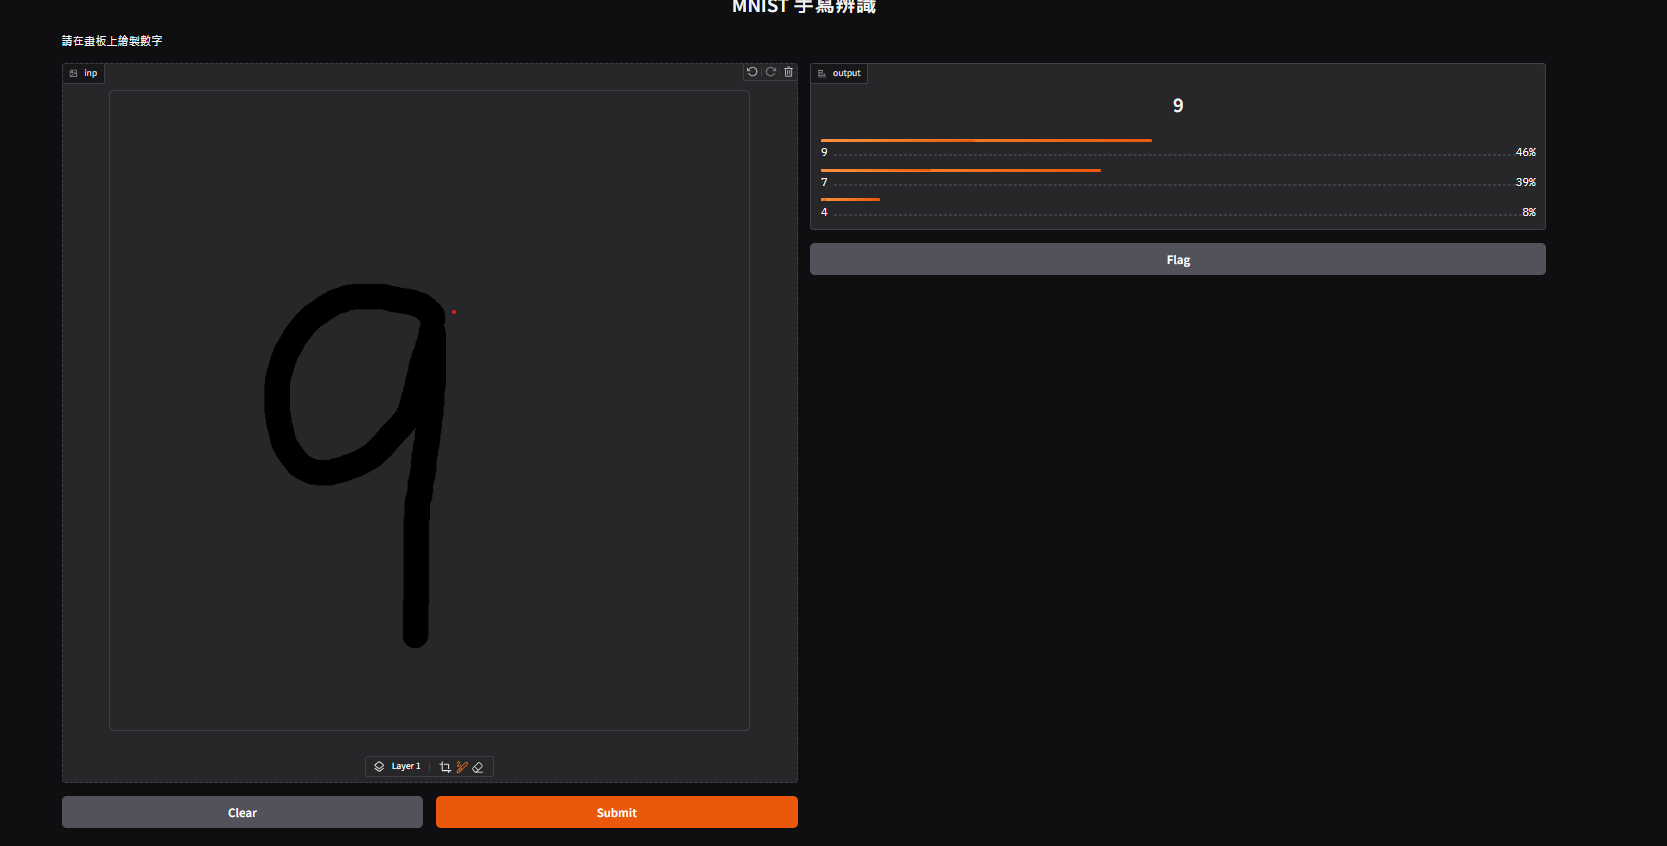



設定神經元(這樣的設計讓較高層次的抽象逐步提煉，並且逐漸減少參數量，有助於降低過擬合的風險)
神經網絡改為4+1層(因為有做augmentation所以加了一層flatten層幫我做reshape)

In [121]:
N1 = 256
N2 = 128
N3 = 64
N4 = 32

In [122]:
!pip install --upgrade gradio


In [123]:
%matplotlib inline

# 標準數據分析、畫圖套件
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 神經網路方面
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

# 互動設計用
from ipywidgets import interact_manual

# 神速打造 web app 的 Gradio
import gradio as gr

###由 Keras 讀入 MNIST

讀取資料庫

In [124]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [125]:
print(f'訓練資料總筆數為 {len(x_train)} 筆資料')
print(f'測試資料總筆數為 {len(x_test)} 筆資料')

訓練資料總筆數為 60000 筆資料
測試資料總筆數為 10000 筆資料


In [126]:
def show_xy(n=0):
    ax = plt.gca()
    X = x_train[n]
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(X, cmap = 'Greys')
    print(f'本資料 y 給定的答案為: {y_train[n]}')

In [127]:
interact_manual(show_xy, n=(0,59999));

interactive(children=(IntSlider(value=0, description='n', max=59999), Button(description='Run Interact', style…

In [128]:
def show_data(n = 100):
    X = x_train[n]
    print(X)

In [129]:
interact_manual(show_data, n=(0,59999));

interactive(children=(IntSlider(value=100, description='n', max=59999), Button(description='Run Interact', sty…

In [130]:
x_train = x_train.reshape(60000, 784)/255
x_test = x_test.reshape(10000, 784)/255

In [131]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# 將原本的 28x28 數據 reshape 為 (28,28,1)
x_train_aug = x_train.reshape(-1, 28, 28, 1)
x_test_aug = x_test.reshape(-1, 28, 28, 1)

# 定義 augmentation，只做隨機縮放和小角度旋轉（不超過15度）
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,  # 小角度旋轉
    zoom_range=0.1      # 隨機縮放
)

datagen.fit(x_train_aug)


In [132]:
n = 87
y_train[n]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

和我們想的一樣! 至此我們可以打造我們的神經網路了。

In [133]:
model = Sequential()

In [134]:
from tensorflow.keras.layers import Flatten
model.add(Flatten(input_shape=(28,28,1)))
model.add(Dense(N1, input_dim=784, activation='relu'))
model.add(Dense(N2, activation='relu'))
model.add(Dense(N3, activation='relu'))
model.add(Dense(N4, activation='relu'))
model.add(Dense(10, activation='softmax'))

至此我們的第一個神經網路就建好了!

In [135]:
from tensorflow.keras.optimizers import Adam

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)


我們可以檢視我們神經網路的架構, 可以確認一下是不是和我們想像的一樣。

In [136]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 244,522 (955.16 KB)

 Trainable params: 244,522 (955.16 KB)

 Non-trainable params: 0 (0.00 B)

In [138]:
model.fit(datagen.flow(x_train_aug, y_train, batch_size=100), epochs=20)

Epoch 1/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.9836 - loss: 0.0532
Epoch 2/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.9841 - loss: 0.0506
Epoch 3/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.9850 - loss: 0.0446
Epoch 4/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.9857 - loss: 0.0439
Epoch 5/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.9857 - loss: 0.0431
Epoch 6/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.9862 - loss: 0.0439
Epoch 7/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9886 - loss: 0.0353
Epoch 8/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.9891 - loss: 0.0345
Epoch 9/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.9863 - loss: 0.0422
Epoch 10/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.9883 - loss: 0.0343
Epoch 11/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.9904 - loss: 0.0317
Epoch 12/20
600/600 ━━━━━━━━━━

In [139]:
loss, acc = model.evaluate(x_test_aug, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9846 - loss: 0.0555


In [140]:
print(f"測試資料正確率 {acc*100:.2f}%")

測試資料正確率 98.66%


我們 "predict" 放的是我們神經網路的學習結果。做完之後用 argmax 找到數值最大的那一項。

In [141]:
predict = np.argmax(model.predict(x_test_aug), axis=-1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [142]:
predict

array([7, 2, 1, ..., 4, 5, 6])

In [143]:
def test(測試編號):
    plt.imshow(x_test[測試編號].reshape(28,28), cmap='Greys')
    print('神經網路判斷為:', predict[測試編號])

In [144]:
interact_manual(test, 測試編號=(0, 9999));

interactive(children=(IntSlider(value=4999, description='測試編號', max=9999), Button(description='Run Interact', …

神經網絡的總分

In [145]:
score = model.evaluate(x_test_aug, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9846 - loss: 0.0555


In [146]:
print('loss:', score[0])
print('正確率', score[1])

loss: 0.051389794796705246
正確率 0.9865999817848206


###用 Gradio 來展示

In [147]:
def resize_image(inp):
    # 若輸入為字典，檢查並提取圖像資料
    if isinstance(inp, dict):
        if "data" in inp:
            image_data = inp["data"]
        elif "layers" in inp:
            image_data = inp["layers"][0]
        else:
            raise ValueError("無法識別輸入的圖像資料結構")
    else:
        image_data = inp

    # 將取得的圖像資料轉換為 numpy 陣列
    image = np.array(image_data, dtype=np.uint8)

    # 轉換為 PIL 影像
    image_pil = Image.fromarray(image)

    # 如果圖像為 RGBA 模式，將 Alpha 通道轉成白色背景
    if image_pil.mode == "RGBA":
        background = Image.new("RGB", image_pil.size, (255, 255, 255))
        background.paste(image_pil, mask=image_pil.split()[3])
        image_pil = background

    # 轉換為灰階圖像
    image_gray = image_pil.convert("L")

    # 將灰階圖像縮放到 28x28，轉回 numpy 陣列
    img_array = np.array(image_gray.resize((28, 28), resample=Image.LANCZOS))

    # 配合 MNIST 數據集：反轉顏色 (黑白互換)
    img_array = 255 - img_array

    # 縮放到 [0, 1]
    img_array = img_array.astype(np.float32) / 255.0

    # 重新調整 shape 為 (1, 28, 28, 1) 以符合模型輸入要求
    img_array = img_array.reshape(1, 28, 28, 1)

    return img_array


In [148]:
def recognize_digit(inp):
    img_array = resize_image(inp)
    prediction = model.predict(img_array).flatten()
    labels = list('0123456789')
    return {labels[i]: float(prediction[i]) for i in range(10)}

In [ ]:
iface = gr.Interface(
    fn=recognize_digit,
    inputs=gr.Sketchpad(),
    outputs=gr.Label(num_top_classes=3),
    title="MNIST 手寫辨識",
    description="請在畫板上繪製數字"
)


iface.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://8133da364631de9e47.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
